In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [9]:
print("Loading master dataset...")
df = pd.read_csv('final_training_data_all_regions.csv')

# --- DEBUGGING STEP (Check this output!) ---
print("\n📊 DATA DIAGNOSTICS:")
print(f"Total Rows Loaded: {len(df)}")
print("Rows per Region:")
print(df['region'].value_counts())
print("-" * 30)

# Rename columns for easier coding
df = df.rename(columns={
    'time': 'time',
    'region': 'region',
    'pm2_5 (μg/m³)': 'target_pm25',
    'temperature_2m (°C)': 'temp',
    'relative_humidity_2m (%)': 'humidity',
    'wind_speed_10m (km/h)': 'wind_speed',
    'wind_direction_10m (°)': 'wind_dir',
    'precipitation (mm)': 'precip',
    'pm10 (μg/m³)': 'pm10',
    'nitrogen_dioxide (μg/m³)': 'no2',
    'carbon_monoxide (μg/m³)': 'co',
    'sulphur_dioxide (μg/m³)': 'so2',
    'ozone (μg/m³)': 'ozone',
    'dust (μg/m³)': 'dust',
    'aerosol_optical_depth ()': 'aerosol'
})

df['time'] = pd.to_datetime(df['time'])

# Sort by Region and Time to ensure lags are calculated correctly per city
df = df.sort_values(by=['region', 'time'])


Loading master dataset...

📊 DATA DIAGNOSTICS:
Total Rows Loaded: 153936
Rows per Region:
region
doha        25656
khor        25656
qatar       25656
rayyan      25656
wakrah      25656
ummsalal    25656
Name: count, dtype: int64
------------------------------


In [10]:
print("\nGenerating features...")

# A. Grouped Lags (Calculate previous hour pollution PER CITY)
# This prevents Doha data from leaking into Al Khor predictions
df['lag1'] = df.groupby('region')['target_pm25'].shift(1)
df['lag24'] = df.groupby('region')['target_pm25'].shift(24)

# B. Time Features
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['day_of_week'] = df['time'].dt.dayofweek

# C. Keep a label column for evaluation later (before we one-hot encode)
df['region_label'] = df['region']

# D. One-Hot Encoding (Converts 'doha' -> column 'city_doha' = 1)
df = pd.get_dummies(df, columns=['region'], prefix='city')

# Drop NaNs created by lags
print(f"Rows before dropna: {len(df)}")
df = df.dropna()
print(f"Rows after dropna: {len(df)}")



Generating features...
Rows before dropna: 153936
Rows after dropna: 153792


In [11]:
# Sort strictly by time for the train/test split (Past -> Future)
df = df.sort_values(by='time')

# Define features (Exclude target, time, and the text label)
features = [col for col in df.columns if col not in ['time', 'target_pm25', 'region_label']]
X = df[features]
y = df['target_pm25']
regions = df['region_label'] # We keep this aligned with X/y to split it too

# Split: 80% Train, 10% Validation, 10% Test
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.9)

X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
X_val, y_val = X.iloc[train_size:val_size], y.iloc[train_size:val_size]

# IMPORTANT: We save the region labels for the test set so we can evaluate per city
X_test = X.iloc[val_size:]
y_test = y.iloc[val_size:]
regions_test = regions.iloc[val_size:]

print(f"\nTraining Set: {len(X_train)} rows")
print(f"Test Set:     {len(X_test)} rows")



Training Set: 123033 rows
Test Set:     15380 rows


In [12]:
print("\nTraining XGBoost Model on ALL regions...")

model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.7,
    colsample_bytree=0.7,
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=200
)



Training XGBoost Model on ALL regions...
[0]	validation_0-rmse:16.55795	validation_1-rmse:16.55078
[200]	validation_0-rmse:1.49605	validation_1-rmse:3.64569
[253]	validation_0-rmse:1.38501	validation_1-rmse:3.64889


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=-1, num_parallel_tree=None, ...)


--- 🌍 REGIONAL PERFORMANCE REPORT ---


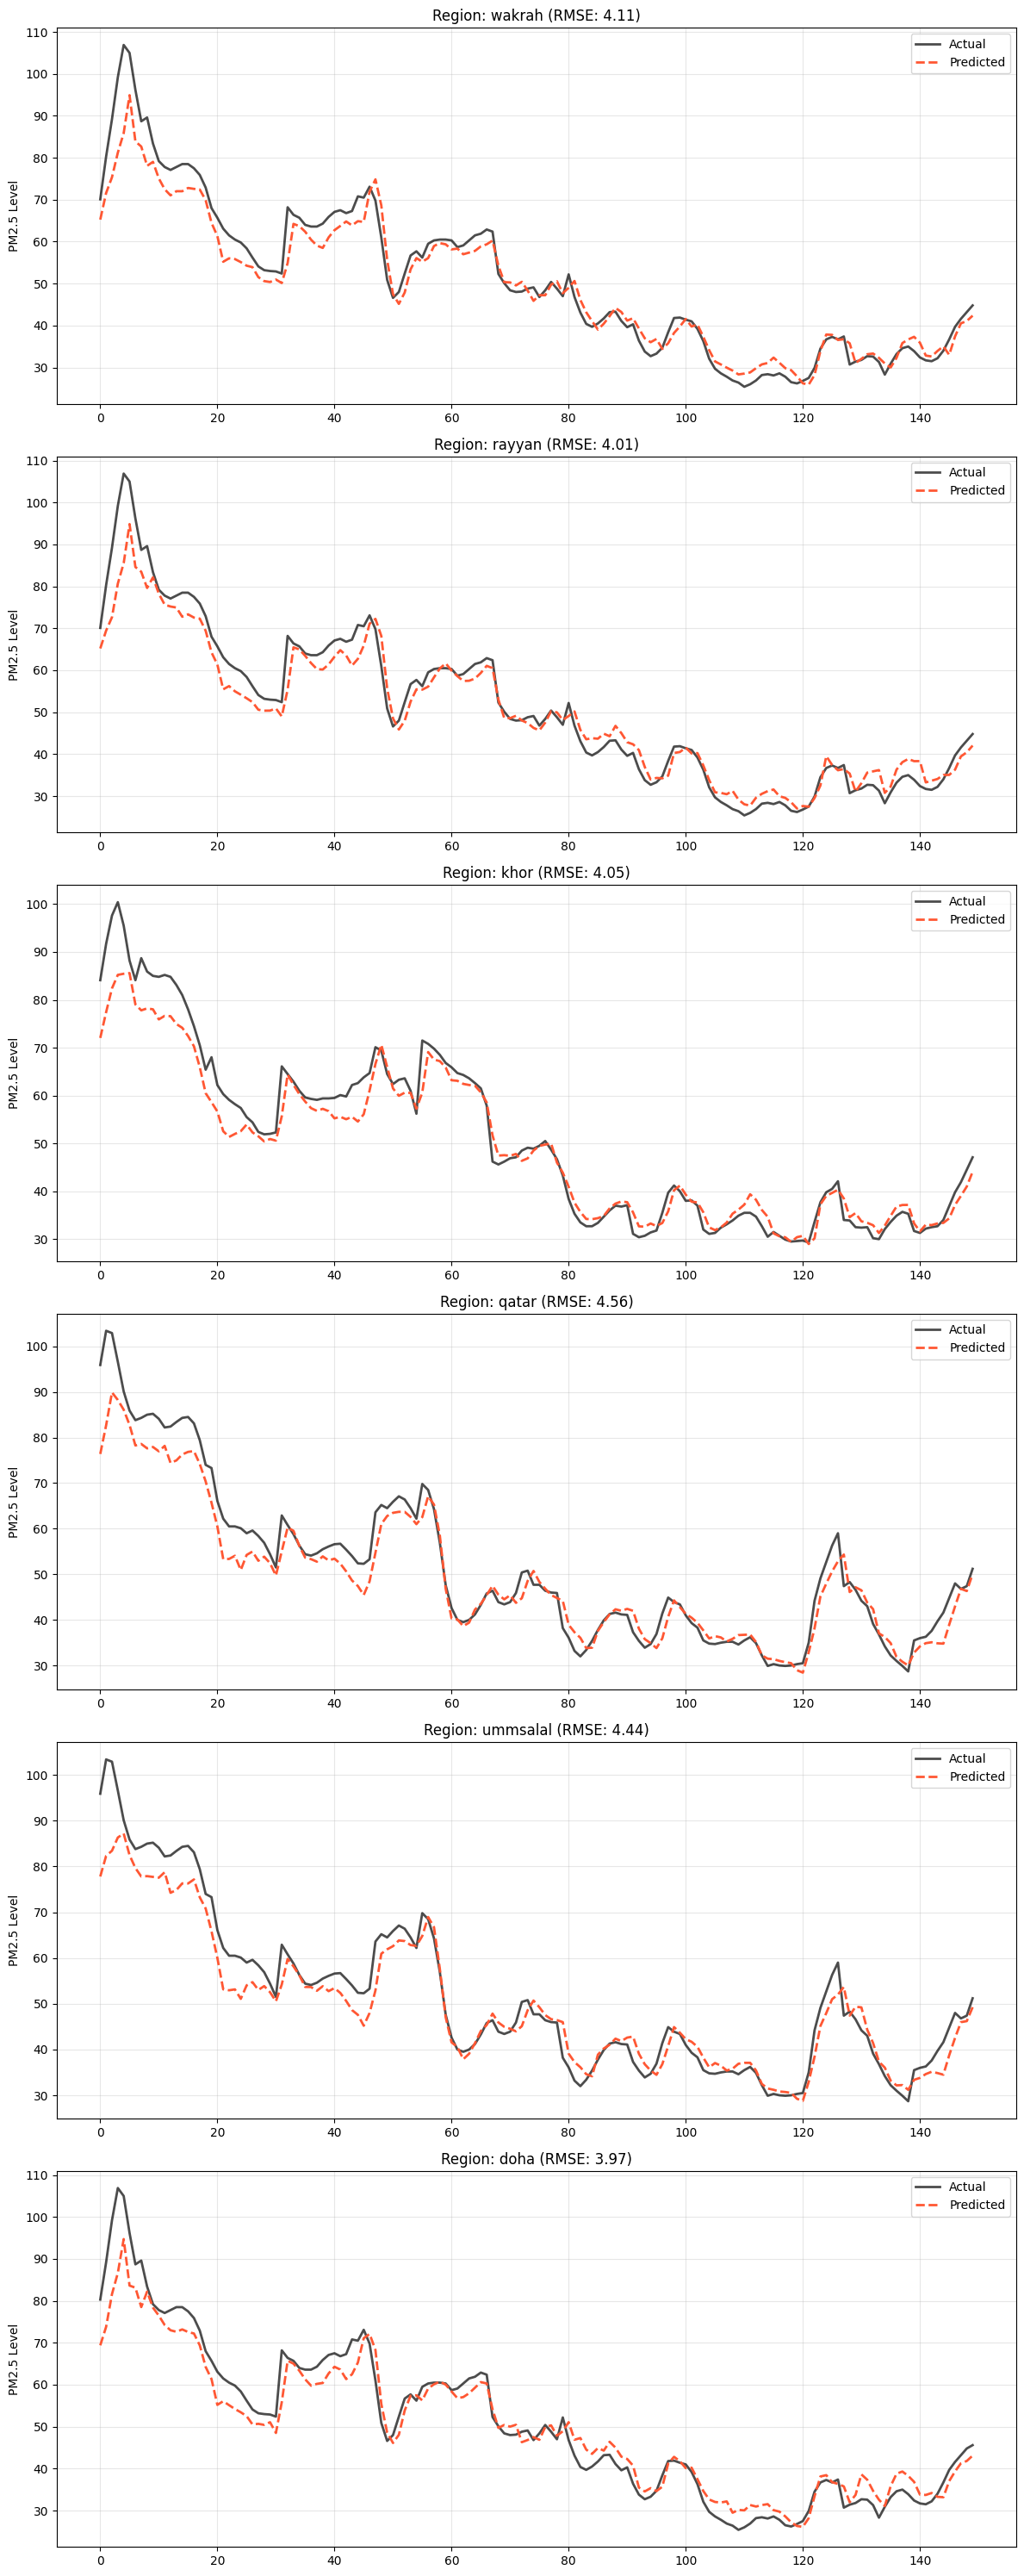

In [13]:
print("\n--- 🌍 REGIONAL PERFORMANCE REPORT ---")

region_metrics = []
unique_regions = regions_test.unique()

# Create a figure for the subplots (One chart per region)
if len(unique_regions) > 0:
    fig, axes = plt.subplots(len(unique_regions), 1, figsize=(12, 5 * len(unique_regions)))
    if len(unique_regions) == 1: axes = [axes] # Handle single region case
else:
    print("⚠️ Warning: No regions found in test set.")

for i, region_name in enumerate(unique_regions):
    # 1. Filter Test Data for this specific region
    indices = regions_test[regions_test == region_name].index

    if len(indices) == 0:
        continue

    X_test_region = X_test.loc[indices]
    y_test_region = y_test.loc[indices]

    # 2. Predict
    preds_region = model.predict(X_test_region)

    # 3. Calculate Metrics
    rmse = np.sqrt(mean_squared_error(y_test_region, preds_region))
    mae = mean_absolute_error(y_test_region, preds_region)
    r2 = r2_score(y_test_region, preds_region)

    region_metrics.append({
        "Region": region_name,
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2 Score": round(r2, 4)
    })

    # 4. Plot Time Series (Zoomed in)
    ax = axes[i]
    # Reset index for plotting cleanly
    y_plot = y_test_region.values[:150]
    p_plot = preds_region[:150]

    ax.plot(y_plot, label='Actual', color='black', linewidth=2, alpha=0.7)
    ax.plot(p_plot, label='Predicted', color='#FF5733', linestyle='--', linewidth=2)
    ax.set_title(f"Region: {region_name} (RMSE: {rmse:.2f})")
    ax.set_ylabel("PM2.5 Level")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [14]:
global_preds = model.predict(X_test)
global_rmse = np.sqrt(mean_squared_error(y_test, global_preds))
global_mae = mean_absolute_error(y_test, global_preds)
global_r2 = r2_score(y_test, global_preds)

region_metrics.append({
    "Region": "GLOBAL (Combined)",
    "RMSE": round(global_rmse, 2),
    "MAE": round(global_mae, 2),
    "R2 Score": round(global_r2, 4)
})

# Display Leaderboard
metrics_df = pd.DataFrame(region_metrics).sort_values(by="RMSE")
print("\n")
print(metrics_df.to_string(index=False))

# Save
metrics_df.to_csv("regional_performance_metrics.csv", index=False)
model.save_model("universal_xgboost_model.json")
print("\n✅ Results saved to 'regional_performance_metrics.csv'")



           Region  RMSE  MAE  R2 Score
             doha  3.97 2.65    0.9165
           rayyan  4.01 2.66    0.9149
             khor  4.05 2.69    0.9188
           wakrah  4.11 2.77    0.9106
GLOBAL (Combined)  4.20 2.82    0.9086
         ummsalal  4.44 3.01    0.8976
            qatar  4.56 3.12    0.8921

✅ Results saved to 'regional_performance_metrics.csv'
